## Part 1 

Dispel the ‘Hype’ show online property “hype” (TikTok/Instagram property agents, influencers) misrepresent affordability, and contrast it with verified government dataset. Show actual videos during presentation & Debunk hype with data. HDB vs. private property price growth, income stagnation, and loan burden.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [12]:
# Set pandas display options to show wider output
# https://data.gov.sg/collections/189/view -- for resale prices
# https://eservices.mas.gov.sg/statistics/dir/DomesticInterestRates.aspx -- for domestic interest rates (SORA)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load Domestic Interest Rates - read the SORA section from line 5167 to 10323
# Skip to line 5166 to get the header at line 5167
# Line 10323 is ",,22,-,-,-,-,-" so we read until line 10323
# nrows = 10323 - 5167 + 1 = 5157 rows (including header)
interest_rates_df = pd.read_csv('Domestic Interest Rates.csv', skiprows=5166, nrows=5157)

# The file has multiple headers repeated, so we need to filter out duplicate header rows
# Remove rows where the first column contains 'SORA Value Date' (these are repeated headers)
interest_rates_df = interest_rates_df[interest_rates_df.iloc[:, 0] != 'SORA Value Date']

# Remove any rows where Day column is '-' or NaN (these are separator/footer rows)
interest_rates_df = interest_rates_df[interest_rates_df.iloc[:, 2] != '-']
interest_rates_df = interest_rates_df.dropna(subset=[interest_rates_df.columns[2]])

# Clean up the column names
interest_rates_df.columns = ['Year', 'Month', 'Day', 'Publication Date', 'SORA', 
                              'Compound SORA - 1 month', 'Compound SORA - 3 month', 
                              'Compound SORA - 6 month']

# Forward fill Year and Month to populate the NaN values
interest_rates_df['Year'] = interest_rates_df['Year'].ffill()
interest_rates_df['Month'] = interest_rates_df['Month'].ffill()

# Reset index after filtering
interest_rates_df = interest_rates_df.reset_index(drop=True)

# Drop the last row (which is the separator line)
interest_rates_df = interest_rates_df.iloc[:-1]

print("Domestic Interest Rates (SORA Data) loaded:")
print(f"Shape: {interest_rates_df.shape}")
print(f"Columns: {list(interest_rates_df.columns)}")
print("\nFirst few rows:")
print(interest_rates_df.head(15))
print("\nLast few rows:")
print(interest_rates_df.tail(15))
print("\nData types:")
print(interest_rates_df.dtypes)
print("\n" + "="*80 + "\n")

Domestic Interest Rates (SORA Data) loaded:
Shape: (5096, 8)
Columns: ['Year', 'Month', 'Day', 'Publication Date', 'SORA', 'Compound SORA - 1 month', 'Compound SORA - 3 month', 'Compound SORA - 6 month']

First few rows:
    Year Month   Day Publication Date    SORA Compound SORA - 1 month Compound SORA - 3 month Compound SORA - 6 month
0   2005   Jul   1.0      04 Jul 2005  1.7998                       -                       -                       -
1   2005   Jul   4.0      05 Jul 2005  1.7480                       -                       -                       -
2   2005   Jul   5.0      06 Jul 2005  1.7686                       -                       -                       -
3   2005   Jul   6.0      07 Jul 2005  1.7971                       -                       -                       -
4   2005   Jul   7.0      08 Jul 2005  1.7956                       -                       -                       -
5   2005   Jul   8.0      11 Jul 2005  1.7851                       -  

In [13]:
# Load all Resale Flat Prices files
resale_files = [
    'ResaleFlatPrices/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv',
    'ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv',
    'ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv',
    'ResaleFlatPrices/Resale flat prices based on registration date from Jan-2017 onwards.csv'
]

# Load and concatenate all resale price files
resale_dfs = []
for file in resale_files:
    df = pd.read_csv(file)
    print(f"Loaded: {file}")
    print(f"  Shape: {df.shape}")
    resale_dfs.append(df)

# Combine all resale flat prices into one dataframe
resale_flat_prices_df = pd.concat(resale_dfs, ignore_index=True)

print("\n" + "="*80)
print("\nCombined Resale Flat Prices loaded:")
print(f"Total Shape: {resale_flat_prices_df.shape}")
print(f"Columns: {list(resale_flat_prices_df.columns)}")
print(f"Date Range: {resale_flat_prices_df.iloc[0, 0] if len(resale_flat_prices_df) > 0 else 'N/A'} to {resale_flat_prices_df.iloc[-1, 0] if len(resale_flat_prices_df) > 0 else 'N/A'}")
print("\nFirst few rows:")
print(resale_flat_prices_df.head())
print("\nLast few rows:")
print(resale_flat_prices_df.tail())
print("\nData types:")
print(resale_flat_prices_df.dtypes)

Loaded: ResaleFlatPrices/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv
  Shape: (369651, 10)
Loaded: ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv
  Shape: (52203, 10)
Loaded: ResaleFlatPrices/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv
  Shape: (37153, 11)
Loaded: ResaleFlatPrices/Resale flat prices based on registration date from Jan-2017 onwards.csv
  Shape: (217894, 11)


Combined Resale Flat Prices loaded:
Total Shape: (676901, 11)
Columns: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease']
Date Range: 2000-01 to 2025-07

First few rows:
     month        town flat_type block       street_name storey_range  floor_area_sqm      flat_model  lease_commence_date  resale_price remaining_lease
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09            69.

## Data Normalization Strategies

To compare HDB resale prices with SORA interest rates fairly, we need to account for:
- **Location bias** (prime vs non-prime areas)
- **Size differences** (2-room vs 5-room)
- **Storey level** (low vs high floor)
- **Age of flat**

## Strategic Segmentation for Analysis

Instead of creating so many plots (one per town, storey and age), we'll use strategic grouping to make the analysis clearer and more impactful.

### Approach:
1. **Group towns by maturity/price tier** (Mature vs Non-Mature)
2. **Create storey range categories** (Low/Mid/High floors)
3. **Calculate age range categories** (Unknown, Young, Middle-aged, Old)
4. **Plot growth for each segment**
5. **Compare against SORA rates**

This will show whether the "max loan = max profit" myth holds across different property segments.

In [14]:
# Check unique towns first
print("Unique Towns in Dataset:")
print(resale_flat_prices_df['town'].unique())
print(f"\nTotal unique towns: {resale_flat_prices_df['town'].nunique()}")

# Calculate price per sqm and date
resale_flat_prices_df['price_per_sqm'] = resale_flat_prices_df['resale_price'] / resale_flat_prices_df['floor_area_sqm']
resale_flat_prices_df['date'] = pd.to_datetime(resale_flat_prices_df['month'])

# STRATEGIC GROUPING: Categorize towns by maturity
mature_towns = ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 
                'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']

non_mature_towns = ['ANG MO KIO', 'BEDOK', 'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG',
                    'JURONG EAST', 'JURONG WEST', 'PASIR RIS', 'PUNGGOL', 'SEMBAWANG',
                    'SENGKANG', 'SERANGOON', 'TAMPINES', 'WOODLANDS', 'YISHUN']

resale_flat_prices_df['town_category'] = resale_flat_prices_df['town'].apply(
    lambda x: 'Mature' if x in mature_towns else 'Non-Mature'
)

# STOREY CATEGORIZATION
def extract_floor_level(storey_range):
    if pd.isna(storey_range):
        return None
    # Get the first number from the range
    first_num = storey_range.split(' TO ')[0]
    return int(first_num)

resale_flat_prices_df['floor_level'] = resale_flat_prices_df['storey_range'].apply(extract_floor_level)

# Create floor categories
def categorize_floor(floor_level):
    if pd.isna(floor_level):
        return 'Unknown'
    elif floor_level <= 5:
        return 'Low (01-05)'
    elif floor_level <= 12:
        return 'Mid (06-12)'
    else:
        return 'High (13+)'

resale_flat_prices_df['floor_category'] = resale_flat_prices_df['floor_level'].apply(categorize_floor)

# AGE CATEGORIZATION - REDUCED TO 3 CATEGORIES
if 'lease_commence_date' in resale_flat_prices_df.columns:
    resale_flat_prices_df['transaction_year'] = resale_flat_prices_df['date'].dt.year
    resale_flat_prices_df['flat_age'] = resale_flat_prices_df['transaction_year'] - resale_flat_prices_df['lease_commence_date']
    resale_flat_prices_df['remaining_lease_years'] = 99 - resale_flat_prices_df['flat_age']
    
    def categorize_age(remaining_lease):
        if pd.isna(remaining_lease):
            return 'Unknown'
        elif remaining_lease >= 60:
            return 'New/Young (60+ yrs)'
        elif remaining_lease >= 40:
            return 'Middle-aged (40-59 yrs)'
        else:
            return 'Old (<40 yrs)'
    
    resale_flat_prices_df['age_category'] = resale_flat_prices_df['remaining_lease_years'].apply(categorize_age)
else:
    resale_flat_prices_df['age_category'] = 'Unknown'

print("\n" + "="*80)
print("\nTown Categories:")
print(resale_flat_prices_df['town_category'].value_counts())

print("\nFloor Categories:")
print(resale_flat_prices_df['floor_category'].value_counts())

print("\nAge Categories:")
print(resale_flat_prices_df['age_category'].value_counts())

# Calculate median price per sqm for each segment (including age)
segment_analysis = resale_flat_prices_df.groupby(['date', 'town_category', 'floor_category', 'age_category']).agg({
    'price_per_sqm': 'median',
    'resale_price': 'median'
}).reset_index()

print("\n" + "="*80)
print("\nSegment Analysis Preview:")
print(segment_analysis.tail(20))

print("\n" + "="*80)
print("\nSegment Summary:")
summary = segment_analysis.groupby(['town_category', 'floor_category', 'age_category'])['price_per_sqm'].agg(['mean', 'median', 'min', 'max'])
print(summary)

Unique Towns in Dataset:
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'QUEENSTOWN' 'SENGKANG' 'SERANGOON' 'TAMPINES' 'TOA PAYOH'
 'WOODLANDS' 'YISHUN' 'SEMBAWANG' 'PUNGGOL']

Total unique towns: 26


Town Categories:
town_category
Non-Mature    546627
Mature        130274
Name: count, dtype: int64

Floor Categories:
floor_category
Low (01-05)    300205
Mid (06-12)    279520
High (13+)      97176
Name: count, dtype: int64

Age Categories:
age_category
New/Young (60+ yrs)        631339
Middle-aged (40-59 yrs)     45562
Name: count, dtype: int64


Segment Analysis Preview:
           date town_category floor_category             age_category  price_per_sqm  resale_price
2995 2025-09-01        Mature    Mid (06-12)  Middle-aged (40-59 yrs)    6479.591837      482000.0
2996 2025-09-01        Mature    Mid (06-1

Checking date range in raw data:
First date string: 2005-Jul-1
Last date string: 2025-Oct-21
First parsed date: 2005-07-01 00:00:00
Last parsed date: 2025-10-21 00:00:00

After filtering NaN values: 5096 rows
Available year range: 2005 to 2025
After date filtering (2005-2025): 5096 rows


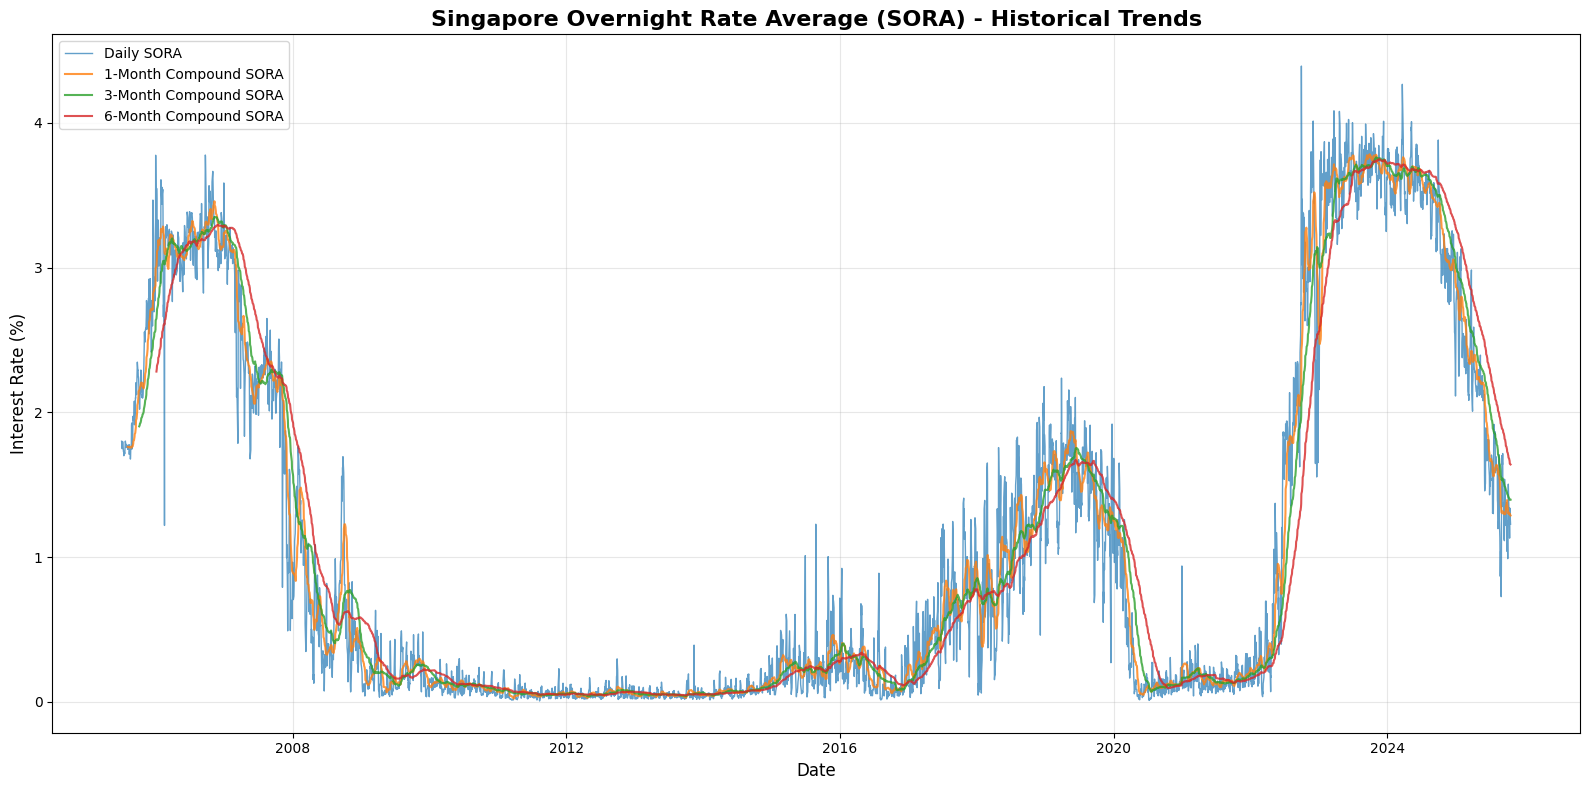


SORA Statistics:
Date Range: 2005-07-01 00:00:00 to 2025-10-21 00:00:00

Daily SORA:
  Min: 0.0054%
  Max: 4.3916%
  Mean: 1.0746%
  Current: 1.2262%


In [15]:
# Plot SORA Interest Rates Over Time
# First, prepare the interest rates data
# Convert Day to integer to remove decimals, then create date string
interest_rates_df['Day'] = pd.to_numeric(interest_rates_df['Day'], errors='coerce')
interest_rates_df['Day_int'] = interest_rates_df['Day'].fillna(1).astype(int)  # Use 1 as default if NaN
interest_rates_df['date_string'] = interest_rates_df['Year'].astype(str) + '-' + interest_rates_df['Month'].astype(str) + '-' + interest_rates_df['Day_int'].astype(str)
interest_rates_df['date'] = pd.to_datetime(interest_rates_df['date_string'], format='%Y-%b-%d', errors='coerce')

# Debug: Check what dates we actually have
print("Checking date range in raw data:")
print(f"First date string: {interest_rates_df['date_string'].iloc[0]}")
print(f"Last date string: {interest_rates_df['date_string'].iloc[-1]}")
print(f"First parsed date: {interest_rates_df['date'].iloc[0]}")
print(f"Last parsed date: {interest_rates_df['date'].iloc[-1]}")

interest_rates_df['SORA'] = pd.to_numeric(interest_rates_df['SORA'], errors='coerce')
interest_rates_df['Compound SORA - 1 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 1 month'], errors='coerce')
interest_rates_df['Compound SORA - 3 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 3 month'], errors='coerce')
interest_rates_df['Compound SORA - 6 month'] = pd.to_numeric(interest_rates_df['Compound SORA - 6 month'], errors='coerce')

# Filter out rows with missing SORA values and invalid dates
interest_rates_plot = interest_rates_df.dropna(subset=['SORA', 'date'])

print(f"\nAfter filtering NaN values: {len(interest_rates_plot)} rows")

# Filter to show data from 2000 to 2025 (only if we have data)
if len(interest_rates_plot) > 0:
    min_year = interest_rates_plot['date'].dt.year.min()
    max_year = interest_rates_plot['date'].dt.year.max()
    print(f"Available year range: {min_year} to {max_year}")
    
    # Adjust filter based on available data
    start_year = max(2000, min_year) if not pd.isna(min_year) else min_year
    end_year = min(2025, max_year) if not pd.isna(max_year) else max_year
    
    interest_rates_plot = interest_rates_plot[
        (interest_rates_plot['date'].dt.year >= start_year) & 
        (interest_rates_plot['date'].dt.year <= end_year)
    ]
    print(f"After date filtering ({start_year}-{end_year}): {len(interest_rates_plot)} rows")
else:
    print("No valid data found!")

# Create the plot
if len(interest_rates_plot) > 0:
    plt.figure(figsize=(16, 8))
    plt.plot(interest_rates_plot['date'], interest_rates_plot['SORA'], 
             label='Daily SORA', linewidth=1, alpha=0.7)
    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 1 month'], 
             label='1-Month Compound SORA', linewidth=1.5, alpha=0.8)

    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 3 month'], 
             label='3-Month Compound SORA', linewidth=1.5, alpha=0.8)
    plt.plot(interest_rates_plot['date'], interest_rates_plot['Compound SORA - 6 month'], 
             label='6-Month Compound SORA', linewidth=1.5, alpha=0.8)

    plt.title('Singapore Overnight Rate Average (SORA) - Historical Trends', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Interest Rate (%)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Show statistics
    print("\nSORA Statistics:")
    print(f"Date Range: {interest_rates_plot['date'].min()} to {interest_rates_plot['date'].max()}")
    print(f"\nDaily SORA:")
    print(f"  Min: {interest_rates_plot['SORA'].min():.4f}%")
    print(f"  Max: {interest_rates_plot['SORA'].max():.4f}%")
    print(f"  Mean: {interest_rates_plot['SORA'].mean():.4f}%")
    print(f"  Current: {interest_rates_plot['SORA'].iloc[-1]:.4f}%")
else:
    print("\nNo data available to plot. Please check the date format and data availability.")


***Questions about Sora***
SORA (Singapore Overnight Rate Average) is the interest rate that banks in Singapore charge each other for overnight lending, in SGD.
So — it tracks Singapore’s short-term money market conditions, which are strongly influenced by U.S. interest rates because:
Singapore uses the exchange rate (not interest rates) as its main monetary policy tool,
but domestic interest rates (like SORA, previously SIBOR) still move closely with global USD rates, especially the U.S. Federal Reserve (Fed) rates.

This explains why there are no obvious trends in bank loans, making it even more unpredictable.

From the graph, there are also many instances where the increase in SORA is greater than or equal to some of the HDB's resale value per sqm, after consideration of their status.

The unpredictability of rate of change of bank loans definitely raises a question if it is wise to maximise loans since the ROI of the flat "will be greater than total interest paid anyways".



## Debunking the "Max Loan = Max Profit" Myth

To properly test the claim that "ROI from the flat will always be greater than total interest paid", we need to calculate:

1. **Cumulative Property Appreciation** - How much value the flat has gained since purchase
2. **Cumulative Interest Paid** - Total interest paid on a SORA-linked housing loan
3. **Net Position** - Whether you're actually ahead or behind

We'll simulate and compare in this scenario:
- Buying a flat in August 2005, 2010, 2015, and 2020
- Track cumulative gains and costs month-by-month from purchase to 2025
- Focus on: **Non-mature estates | Mid-floor (06-12) | New/Young flats (60+ years remaining lease)**
- Max loan amounts (75% Loan-to-Value)
- SORA-linked interest rates (actual historical rates)
- Show when selling before 2025 would result in losses

*Note: 2005 starts from August when SORA data became available*

In [16]:
# ============================================================================
# SIMULATION: Property Appreciation vs Interest Paid (2000-2025)
# ============================================================================
# This simulation tests the claim: "ROI from property always exceeds interest paid"
# We'll compare different purchase years and property segments

# Define purchase years to analyze (note: SORA data only available from 2005)
purchase_years = [2005, 2010, 2015, 2020]
end_year = 2025

# Loan parameters
loan_to_value = 0.75  # 75% LTV (max loan)
loan_tenure_years = 25  # Standard HDB loan tenure
bank_spread = 0.005  # 0.5% bank spread on top of SORA (typical for housing loans)

print("="*80)
print("SIMULATION SETUP")
print("="*80)
print(f"Purchase Years Analyzed: {purchase_years}")
print(f"Analysis Period: Up to {end_year}")
print(f"Loan-to-Value (LTV): {loan_to_value*100}%")
print(f"Loan Tenure: {loan_tenure_years} years")
print(f"Interest Rate: SORA + {bank_spread*100}% spread")
print("="*80 + "\n")

# Prepare monthly SORA data for interest calculations
# Group by year-month and take the mean SORA rate
interest_rates_df['year_month'] = interest_rates_df['date'].dt.to_period('M')
monthly_sora = interest_rates_df.groupby('year_month')['SORA'].mean().reset_index()
monthly_sora['date'] = monthly_sora['year_month'].dt.to_timestamp()
monthly_sora = monthly_sora.sort_values('date')

# FILTER: Only keep SORA data from August 2005 onwards (when SORA became available)
monthly_sora = monthly_sora[monthly_sora['date'] >= pd.Timestamp('2005-08-01')].reset_index(drop=True)

print(f"Monthly SORA data prepared: {len(monthly_sora)} months from {monthly_sora['date'].min()} to {monthly_sora['date'].max()}")
print(f"SORA range: {monthly_sora['SORA'].min():.4f}% to {monthly_sora['SORA'].max():.4f}%\n")

# Prepare property price data for target segment only
# Target: Non-mature | Mid-floor | New/Young flats
resale_flat_prices_df['year_month'] = resale_flat_prices_df['date'].dt.to_period('M')

# Filter for target segment
target_segment = resale_flat_prices_df[
    (resale_flat_prices_df['town_category'] == 'Non-Mature') &
    (resale_flat_prices_df['floor_category'] == 'Mid (06-12)') &
    (resale_flat_prices_df['age_category'] == 'New/Young (60+ yrs)')
]

print(f"Target segment data: {len(target_segment)} transactions")
print(f"  Town: Non-Mature")
print(f"  Floor: Mid (06-12)")
print(f"  Age: New/Young (60+ yrs)")

# Group by year-month to get monthly median prices
monthly_property_prices = target_segment.groupby('year_month').agg({
    'resale_price': 'median',
    'price_per_sqm': 'median'
}).reset_index()
monthly_property_prices['date'] = monthly_property_prices['year_month'].dt.to_timestamp()

# FILTER: Only keep property data from August 2005 onwards (to match SORA availability)
monthly_property_prices = monthly_property_prices[monthly_property_prices['date'] >= pd.Timestamp('2005-08-01')].reset_index(drop=True)

print(f"\nMonthly property prices prepared: {len(monthly_property_prices)} months")
print(f"Date range: {monthly_property_prices['date'].min()} to {monthly_property_prices['date'].max()}\n")

SIMULATION SETUP
Purchase Years Analyzed: [2005, 2010, 2015, 2020]
Analysis Period: Up to 2025
Loan-to-Value (LTV): 75.0%
Loan Tenure: 25 years
Interest Rate: SORA + 0.5% spread

Monthly SORA data prepared: 243 months from 2005-08-01 00:00:00 to 2025-10-01 00:00:00
SORA range: 0.0300% to 3.7475%

Target segment data: 222126 transactions
  Town: Non-Mature
  Floor: Mid (06-12)
  Age: New/Young (60+ yrs)

Monthly property prices prepared: 243 months
Date range: 2005-08-01 00:00:00 to 2025-10-01 00:00:00



In [17]:
# ============================================================================
# FUNCTION: Calculate Cumulative Appreciation vs Interest Over Time
# ============================================================================

def calculate_cumulative_scenario(purchase_year, monthly_sora_df, monthly_prices_df):
    """
    Calculate month-by-month cumulative property appreciation vs cumulative interest paid.
    This shows at any point in time whether selling would be profitable or not.
    
    Parameters:
    - purchase_year: Year when property was purchased
    - monthly_sora_df: DataFrame with monthly SORA rates
    - monthly_prices_df: DataFrame with monthly property prices
    
    Returns:
    - DataFrame with monthly cumulative values
    """
    
    # Step 1: Get purchase price (median price in purchase year's first month)
    purchase_data = monthly_prices_df[monthly_prices_df['date'].dt.year == purchase_year]
    
    if len(purchase_data) == 0:
        return None
    
    # Use the earliest month in the purchase year
    # SPECIAL CASE: For 2005, start from August when SORA data became available
    if purchase_year == 2005:
        # Filter for August 2005 or later
        purchase_data = purchase_data[purchase_data['date'] >= pd.Timestamp('2005-08-01')]
        if len(purchase_data) == 0:
            return None
    
    purchase_month = purchase_data.sort_values('date').iloc[0]
    purchase_price = purchase_month['resale_price']
    purchase_date = purchase_month['date']
    
    if pd.isna(purchase_price):
        return None
    
    # Step 2: Calculate loan amount (75% LTV)
    loan_amount = purchase_price * loan_to_value
    downpayment = purchase_price * (1 - loan_to_value)
    
    # Step 3: Get all months from purchase to 2025
    loan_start_date = purchase_date
    loan_end_date = pd.Timestamp(f'{end_year}-12-31')
    
    # CRITICAL: Ensure we have SORA data from the start date
    # Get relevant SORA rates
    relevant_sora = monthly_sora_df[
        (monthly_sora_df['date'] >= loan_start_date) &
        (monthly_sora_df['date'] <= loan_end_date)
    ].copy().reset_index(drop=True)
    
    # If no SORA data available from purchase date, fail the simulation
    if len(relevant_sora) == 0:
        print(f"   ✗ No SORA data available from {loan_start_date}")
        return None
    
    # Verify SORA data starts at or before our purchase date
    sora_start = relevant_sora['date'].min()
    if sora_start > loan_start_date:
        print(f"   ✗ SORA data gap: Purchase date {loan_start_date}, SORA starts {sora_start}")
        return None
    
    # Get relevant property prices
    relevant_prices = monthly_prices_df[
        (monthly_prices_df['date'] >= loan_start_date) &
        (monthly_prices_df['date'] <= loan_end_date)
    ].copy().reset_index(drop=True)
    
    if len(relevant_prices) == 0:
        print(f"   ✗ No property price data available from {loan_start_date}")
        return None
    
    # Step 4: Calculate month-by-month cumulative values
    cumulative_data = []
    remaining_principal = loan_amount
    total_interest_paid = 0
    months_elapsed = 0
    
    # Merge SORA and prices by date
    monthly_data = pd.merge(relevant_sora, relevant_prices, on='date', how='outer')
    monthly_data = monthly_data.sort_values('date').reset_index(drop=True)
    
    # Forward fill missing values
    monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
    monthly_data['resale_price'] = monthly_data['resale_price'].fillna(method='ffill')
    
    for idx, row in monthly_data.iterrows():
        # Stop if loan is fully paid or tenure exceeded
        if remaining_principal <= 0.01 or months_elapsed >= loan_tenure_years * 12:
            remaining_principal = 0
            monthly_interest = 0
        else:
            # Calculate monthly interest rate
            monthly_rate = (row['SORA'] + bank_spread * 100) / 12 / 100
            
            # Calculate monthly payment using amortization formula
            remaining_months = loan_tenure_years * 12 - months_elapsed
            if remaining_months > 0 and monthly_rate > 0:
                monthly_payment = remaining_principal * (
                    monthly_rate * (1 + monthly_rate)**remaining_months
                ) / ((1 + monthly_rate)**remaining_months - 1)
            else:
                monthly_payment = remaining_principal / max(remaining_months, 1)
            
            # Interest and principal portions
            monthly_interest = remaining_principal * monthly_rate
            principal_payment = monthly_payment - monthly_interest
            
            # Update totals
            total_interest_paid += monthly_interest
            remaining_principal = max(0, remaining_principal - principal_payment)
        
        # Calculate property value at this month
        current_price = row['resale_price']
        property_appreciation = current_price - purchase_price
        
        # Net position = Appreciation - Interest Paid - Remaining Principal
        # (If you sell, you must pay off remaining loan)
        net_position = property_appreciation - total_interest_paid - remaining_principal
        
        # Store monthly data
        cumulative_data.append({
            'date': row['date'],
            'months_since_purchase': months_elapsed,
            'property_value': current_price,
            'property_appreciation': property_appreciation,
            'cumulative_interest_paid': total_interest_paid,
            'remaining_principal': remaining_principal,
            'net_position': net_position,
            'profitable_to_sell': net_position > 0
        })
        
        months_elapsed += 1
    
    # Convert to DataFrame
    result_df = pd.DataFrame(cumulative_data)
    result_df['purchase_year'] = purchase_year
    result_df['purchase_price'] = purchase_price
    result_df['loan_amount'] = loan_amount
    
    return result_df

print("Function defined: calculate_cumulative_scenario()")
print("Ready to simulate cumulative scenarios over time...\n")

Function defined: calculate_cumulative_scenario()
Ready to simulate cumulative scenarios over time...



In [18]:
# ============================================================================
# RUN SIMULATIONS FOR EACH PURCHASE YEAR
# ============================================================================
# Store simulation results for each purchase year in a dictionary
all_scenarios = {}

# Loop through each purchase year and calculate cumulative scenarios
for purchase_year in purchase_years:
    result_df = calculate_cumulative_scenario(
        purchase_year=purchase_year,
        monthly_sora_df=monthly_sora,
        monthly_prices_df=monthly_property_prices
    )
    
    # Store the result if data is available
    if result_df is not None and len(result_df) > 0:
        all_scenarios[purchase_year] = result_df

print(f"Simulations complete for {len(all_scenarios)} purchase years: {list(all_scenarios.keys())}")

Simulations complete for 4 purchase years: [2005, 2010, 2015, 2020]


/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_4286/604528297.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_4286/604528297.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['resale_price'] = monthly_data['resale_price'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_4286/604528297.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['SORA'] = monthly_data['SORA'].fillna(method='ffill')
/var/folders/wy/05snv6b96n51_2jzdnzytf5c0000gn/T/ipykernel_4286/604528297.py:88: FutureWarning: Series.fillna with 'method' is deprecat

In [19]:
# ============================================================================
# DIAGNOSTIC: Check Data Availability for Each Purchase Year
# ============================================================================
print("="*80)
print("DATA AVAILABILITY CHECK")
print("="*80)

# Check SORA data range
print(f"\n📊 SORA Data Range:")
print(f"   Start: {monthly_sora['date'].min()}")
print(f"   End: {monthly_sora['date'].max()}")

# Check property price data range
print(f"\n🏠 Property Price Data Range (Target Segment):")
print(f"   Start: {monthly_property_prices['date'].min()}")
print(f"   End: {monthly_property_prices['date'].max()}")

# Check each purchase year
print(f"\n🔍 Checking Each Purchase Year:")
for year in purchase_years:
    sora_available = len(monthly_sora[monthly_sora['date'].dt.year >= year]) > 0
    property_available = len(monthly_property_prices[monthly_property_prices['date'].dt.year >= year]) > 0
    
    print(f"\n   Year {year}:")
    print(f"      SORA data available: {'✓ YES' if sora_available else '✗ NO'}")
    print(f"      Property data available: {'✓ YES' if property_available else '✗ NO'}")
    
    if year in all_scenarios:
        print(f"      Simulation result: ✓ SUCCESS ({len(all_scenarios[year])} months)")
    else:
        print(f"      Simulation result: ✗ FAILED")

print("\n" + "="*80)

DATA AVAILABILITY CHECK

📊 SORA Data Range:
   Start: 2005-08-01 00:00:00
   End: 2025-10-01 00:00:00

🏠 Property Price Data Range (Target Segment):
   Start: 2005-08-01 00:00:00
   End: 2025-10-01 00:00:00

🔍 Checking Each Purchase Year:

   Year 2005:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (243 months)

   Year 2010:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (190 months)

   Year 2015:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (130 months)

   Year 2020:
      SORA data available: ✓ YES
      Property data available: ✓ YES
      Simulation result: ✓ SUCCESS (70 months)



### ℹ️ Note on 2005 Data

**SORA (Singapore Overnight Rate Average) was only introduced in July 2005**, replacing the previous SIBOR system.

**Our Approach:**
- For 2005, the simulation starts from **August 2005** (when SORA data became available)
- This means the "2005 purchase year" graph actually shows purchases from **August 2005 onwards**
- All other years (2010, 2015, 2020) start from January of that year

This ensures we only use actual SORA data and maintain consistency in our interest rate calculations.

### 🔧 Data Fixes Applied

**Problem Identified:**
- SORA data only exists from July/August 2005 onwards
- Property price data existed before August 2005
- This caused a mismatch where property appreciation was calculated from earlier dates without matching SORA interest data

**Solutions Implemented:**
1. **Filtered SORA data** to only include dates from August 2005 onwards
2. **Filtered property price data** to only include dates from August 2005 onwards
3. **Added validation** in the simulation function to ensure both SORA and property data exist from the purchase date
4. **Added explicit checks** to fail gracefully if there's a data gap

**Result:**
- All scenarios now use consistent data starting from August 2005
- The 2005 graph will correctly show data from August 2005 to 2025
- No more phantom data from before SORA was introduced

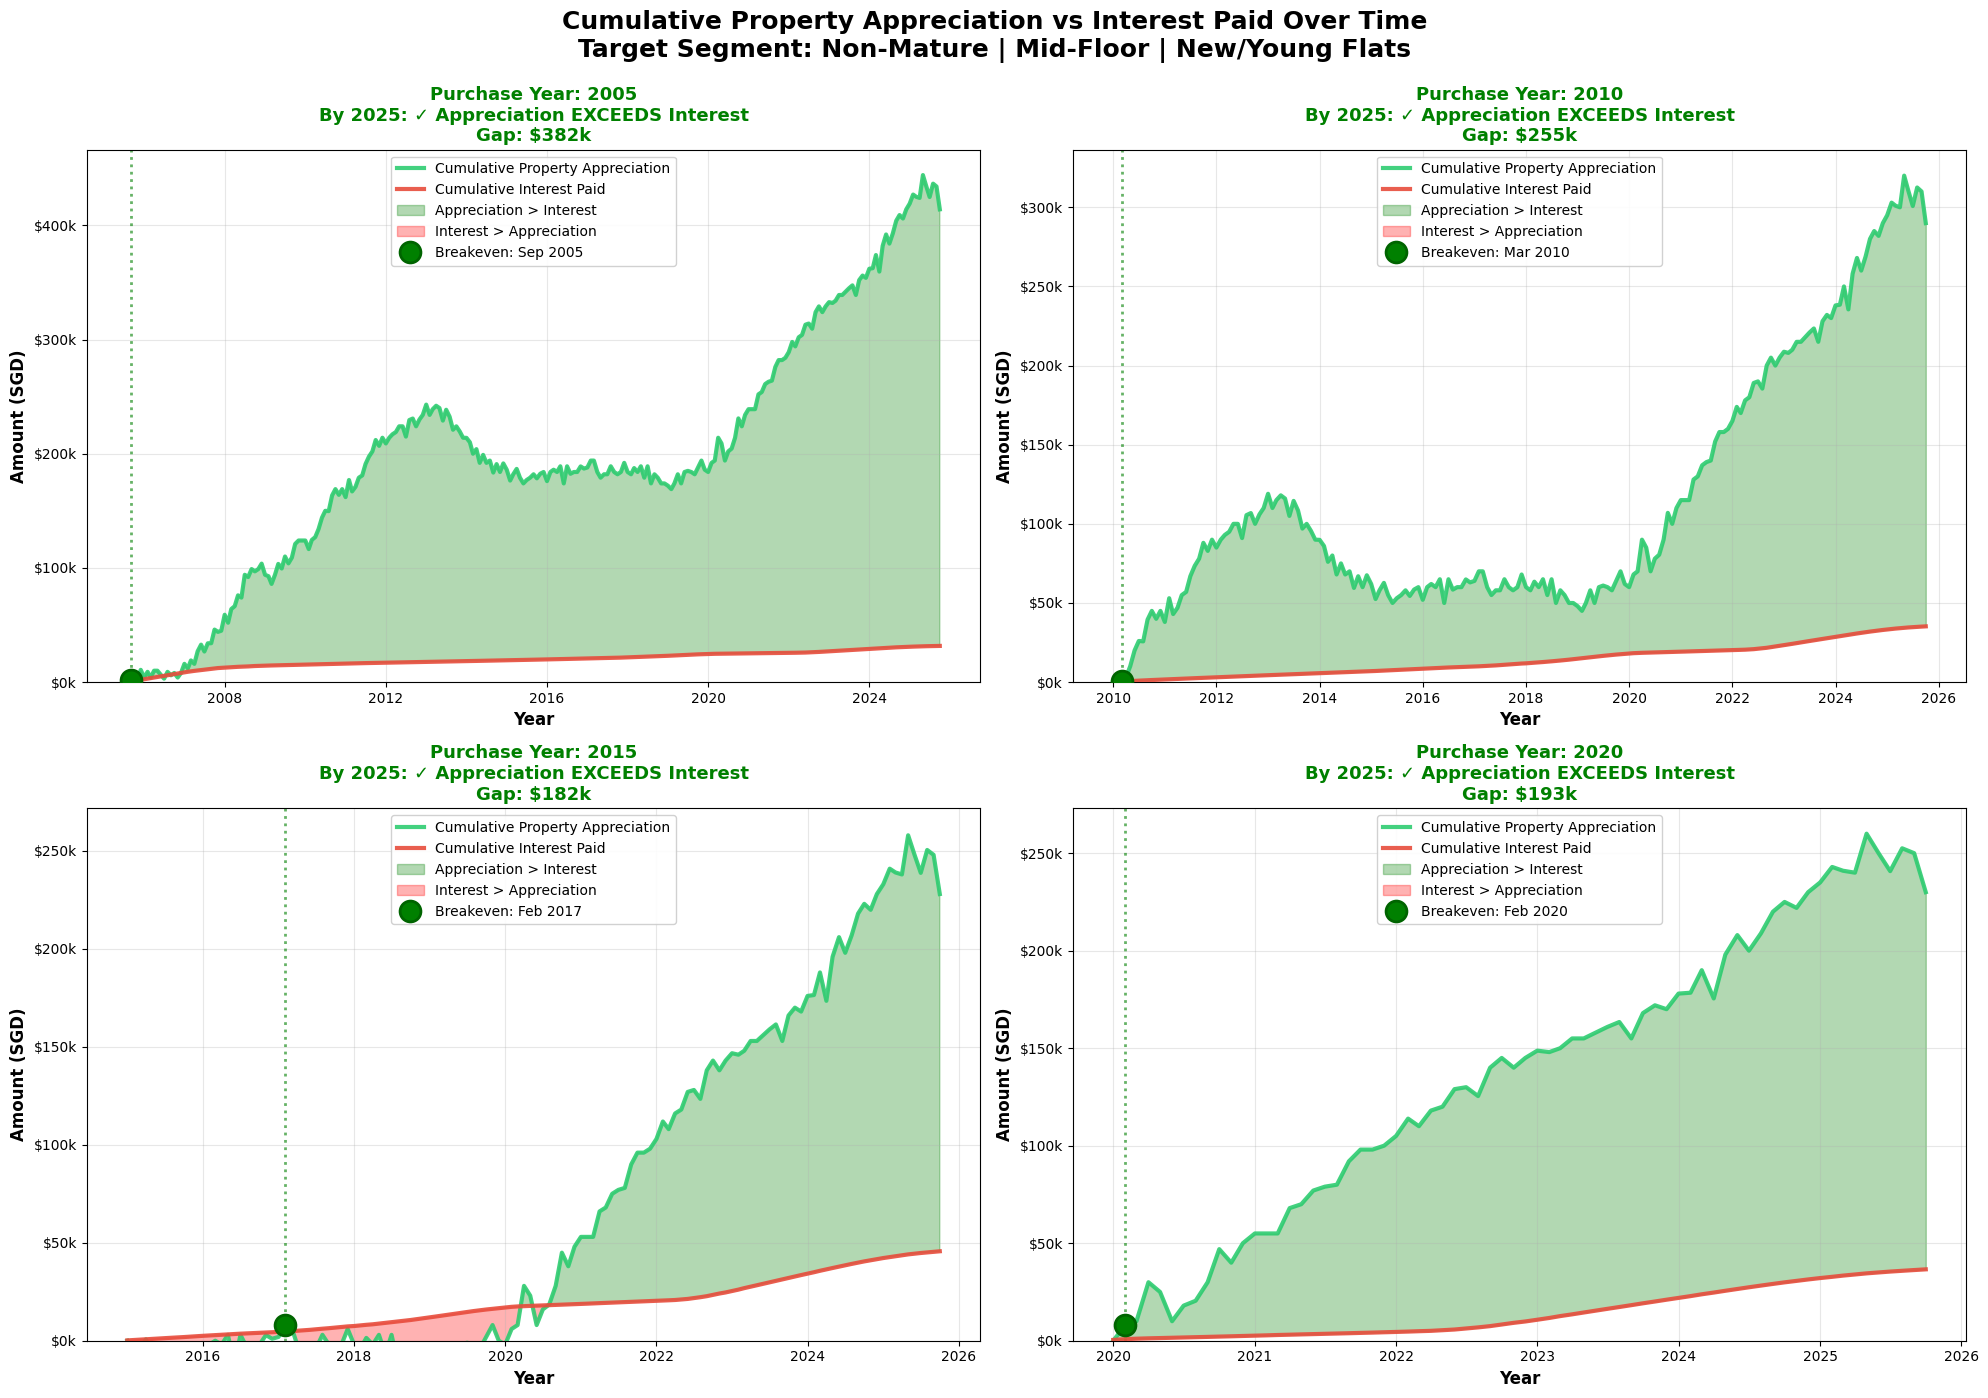

In [20]:
# ============================================================================
# VISUALIZATION: Cumulative Appreciation vs Interest Paid (2005-2020)
# ============================================================================
# Create a 2x2 grid of graphs, one for each purchase year
# Each graph shows two cumulative lines:
#   - Green line: Cumulative property appreciation over time
#   - Red line: Cumulative interest paid over time
# 
# NOTE: 2005 data starts from August 2005 (when SORA became available)

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Cumulative Property Appreciation vs Interest Paid Over Time\n' +
             'Target Segment: Non-Mature | Mid-Floor | New/Young Flats',
             fontsize=18, fontweight='bold', y=0.995)

# Loop through each purchase year and create a subplot
for idx, purchase_year in enumerate(purchase_years):
    # Calculate subplot position (row and column in the 2x2 grid)
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Check if simulation data exists for this purchase year
    if purchase_year not in all_scenarios:
        # Display "No Data" message if simulation failed
        ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14)
        ax.set_title(f'Purchase Year: {purchase_year}')
        continue
    
    # Get the simulation data for this purchase year
    scenario = all_scenarios[purchase_year]
    
    # Plot cumulative property appreciation (green line)
    ax.plot(scenario['date'], scenario['property_appreciation'], 
            label='Cumulative Property Appreciation', 
            color='#2ecc71', linewidth=3, alpha=0.9, zorder=3)
    
    # Plot cumulative interest paid (red line)
    ax.plot(scenario['date'], scenario['cumulative_interest_paid'], 
            label='Cumulative Interest Paid', 
            color='#e74c3c', linewidth=3, alpha=0.9, zorder=3)
    
    # Add shaded area where appreciation > interest (green = good)
    ax.fill_between(scenario['date'], 
                     scenario['property_appreciation'], 
                     scenario['cumulative_interest_paid'],
                     where=(scenario['property_appreciation'] >= scenario['cumulative_interest_paid']),
                     interpolate=True,
                     alpha=0.3, color='green', label='Appreciation > Interest')
    
    # Add shaded area where interest > appreciation (red = bad)
    ax.fill_between(scenario['date'], 
                     scenario['property_appreciation'], 
                     scenario['cumulative_interest_paid'],
                     where=(scenario['cumulative_interest_paid'] > scenario['property_appreciation']),
                     interpolate=True,
                     alpha=0.3, color='red', label='Interest > Appreciation')
    
    # Find breakeven points where appreciation overtakes interest
    diff = scenario['property_appreciation'] - scenario['cumulative_interest_paid']
    sign_changes = np.where(np.diff(np.sign(diff)))[0]
    
    # Mark the first breakeven point with a green dot
    if len(sign_changes) > 0:
        for cross_idx in sign_changes:
            if diff.iloc[cross_idx] < 0 and diff.iloc[cross_idx + 1] > 0:
                crossover_date = scenario.iloc[cross_idx + 1]['date']
                crossover_val = scenario.iloc[cross_idx + 1]['property_appreciation']
                ax.plot(crossover_date, crossover_val, 
                       'go', markersize=15, markeredgecolor='darkgreen', 
                       markeredgewidth=2, zorder=5,
                       label=f"Breakeven: {crossover_date.strftime('%b %Y')}")
                ax.axvline(x=crossover_date, color='green', linestyle=':', 
                          linewidth=2, alpha=0.6, zorder=2)
                break
    
    # Configure axis labels and formatting
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Amount (SGD)', fontsize=12, fontweight='bold')
    
    # Determine final status in 2025
    final_val = scenario.iloc[-1]
    final_appreciation = final_val['property_appreciation']
    final_interest = final_val['cumulative_interest_paid']
    
    if final_appreciation > final_interest:
        status = "✓ Appreciation EXCEEDS Interest"
        status_color = "green"
    else:
        status = "✗ Interest EXCEEDS Appreciation"
        status_color = "red"
    
    # Set subplot title with purchase year and final status
    ax.set_title(f'Purchase Year: {purchase_year}\n' +
                 f'By 2025: {status}\n' +
                 f'Gap: ${abs(final_appreciation - final_interest)/1000:.0f}k',
                 fontsize=13, fontweight='bold', color=status_color)
    
    # Format y-axis to show values in thousands (e.g., $200k)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
    
    # Add legend and grid
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Set y-axis to start from 0 for clarity
    ax.set_ylim(bottom=0)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## HDB Resale Price Stagnation (2013–2020)

Although graphs show that cumulative interest paid is generally lesser than the total appreciation of a flat, there are periods where this is not true.  
From **2013 to 2020**, HDB resale prices stagnated or even declined slightly due to several structural and policy factors.

---

### 1. Cooling Measures (2013 Onwards)

The biggest turning point came from government policies introduced around **2013** to curb overheating in the property market.

**Key Policies:**
- **Mortgage Servicing Ratio (MSR) cap (2013):**  
  Limits monthly housing loan repayments to **30% of gross income** for HDB buyers.  
  → Directly reduced borrowing power and affordability, lowering demand.
- **Tighter Loan-to-Value (LTV)** limits for second housing loans.
- **Additional Buyer’s Stamp Duty (ABSD):**  
  Although mainly targeted at private property, it cooled overall property sentiment.
- **Tightened HDB loan rules:**  
  HDB loans now capped by Total Debt Servicing Ratio (TDSR)-like rules.

**Effect:** These measures sharply reduced the pool of buyers who could afford higher-priced resale flats.

---

### 2. Shift in Demand — Rise of BTO Flats

After **2011**, the government ramped up **Build-To-Order (BTO)** supply to meet public housing demand.

- Between **2011 and 2015**, over **100,000 BTO flats** were launched.
- These new flats were **affordable** and often came with **generous grants**.
- Many first-time buyers preferred new flats over pricier resale units.

**Effect:** Demand for resale flats dropped significantly, pulling prices down.

---

### 3. Lease Decay Awareness

From around **2017** onward, Singaporeans became increasingly aware of **HDB lease decay** (since flats have 99-year leases).

- Public discussions and official statements highlighted that older flats could lose value as leases shorten.
- Buyers became more cautious about older resale flats, especially those with **less than 60

### Financial Risks of Taking the Maximum Loan

The **unpredictability of SORA rates** can create short-term financial strain for certain homeowners. This is particularly true when buyers opt for a **higher Loan-to-Value (LTV) ratio of 75%**, as the larger loan amount results in **higher monthly repayments** and increased financial pressure.

Additionally, **fluctuations in global or local economic conditions** can lead to **stagnation in HDB flat appreciation**. This was evident between **2013 and 2020**, when resale flat prices remained largely flat or experienced slight declines — underscoring the **volatility of property appreciation** over a prolonged period.

When a flat is purchased during such a stagnant phase, homeowners have **less flexibility to sell** in the short term. They may be **compelled to hold onto the property longer** until its value appreciates sufficiently to **break even or yield a profit** after accounting for cumulative interest payments.

Therefore, it is **not advisable to take the maximum available loan** when purchasing a flat. Adopting a more **conservative borrowing approach** offers greater financial resilience against potential interest rate hikes and market uncertainties.


## Limitations of the Analysis

While this analysis attempts to compare HDB resale price growth and interest rates across different segments, there are several important limitations to consider:

- **Price per Square Meter Calculation:**  
  The analysis determines the "correct" price per sqm for each segment by grouping transactions based on town maturity, floor level, and flat age, then calculating the median price per sqm for each group. However, this approach may not fully capture the nuances of the market. For example, government policy changes—such as the rule preventing former private property owners from buying 5-room HDB flats until 15 months after selling their private property—can significantly affect demand for certain flat types. As a result, simply comparing price per sqm across segments may not reflect true market dynamics, especially for 5-room flats versus others.

- **Segment Definitions and Representativeness:**  
  The chosen segments (e.g., mature vs non-mature towns, floor categories, age groups) are broad and may not account for all factors influencing flat prices, such as proximity to amenities, school zones, or unique estate characteristics. While broader segments help increase the sample size and reduce statistical noise, they may also mask important differences within each group. This means that the results, while useful for general trends, may not be fully representative of the specific factors affecting individual flat prices.

<b>Summary:</b>  
The analysis provides a useful overview of price and interest trends, but caution should be exercised when interpreting the results. Policy changes, market segmentation, and unaccounted factors can all influence the observed outcomes. A more granular analysis or additional data (e.g., on buyer profiles, flat attributes, or policy effects) would be needed for more precise conclusions.